In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
import os

In [2]:
files = os.listdir('../data/raw')
cities = set([f.split("_")[0] for f in files])

workloads = []

for c in cities:
    city = pd.DataFrame()
    print("loading:",c)
    for f in files:
        if c in f:
            tmp = pd.read_csv(
                f"../data/raw/{f}",
                parse_dates=['open_date','close_date'],
            )
            city = pd.concat([city,tmp]).reset_index(drop=True)
    print(c,round(len(city[city['close_date'].isna()])/len(city)*100,2),"% close date missing")
    city = time_series_workload(city, c)
    city.to_csv(f"../data/processed/{c}_workload.csv", index=False)
    workloads.append(city)

loading: boston
boston 7.55 % close date missing


100%|██████████| 3659/3659 [14:22<00:00,  4.24it/s]


loading: buffalo
buffalo 0.46 % close date missing


100%|██████████| 3766/3766 [04:29<00:00, 13.96it/s]


loading: oakland
oakland 20.76 % close date missing


100%|██████████| 3766/3766 [05:06<00:00, 12.27it/s]


loading: washington
washington 2.16 % close date missing


100%|██████████| 3731/3731 [11:07<00:00,  5.59it/s]


loading: miami
miami 37.26 % close date missing


100%|██████████| 3903/3903 [21:37<00:00,  3.01it/s]


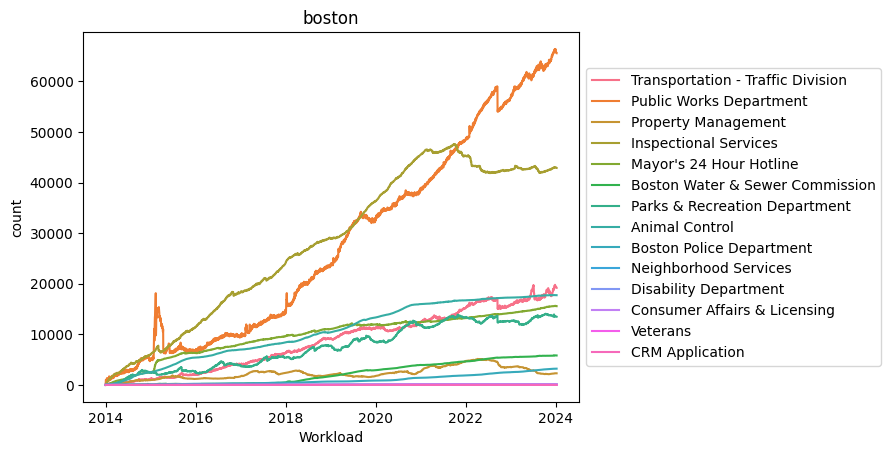

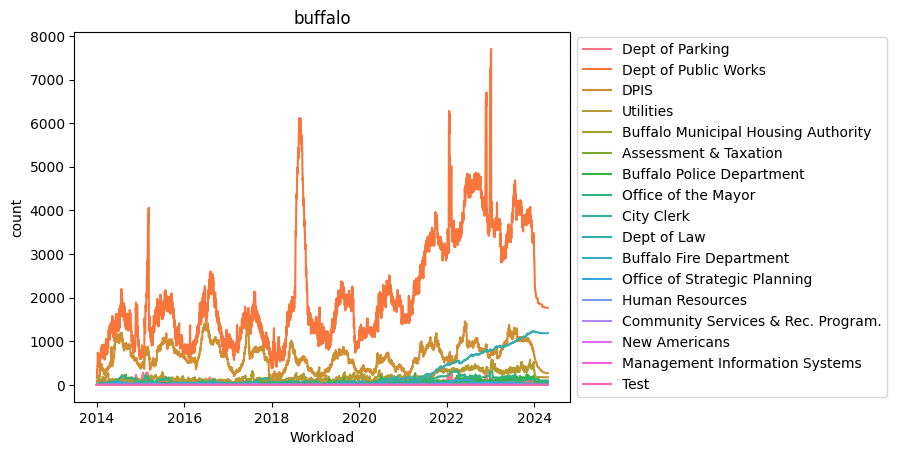

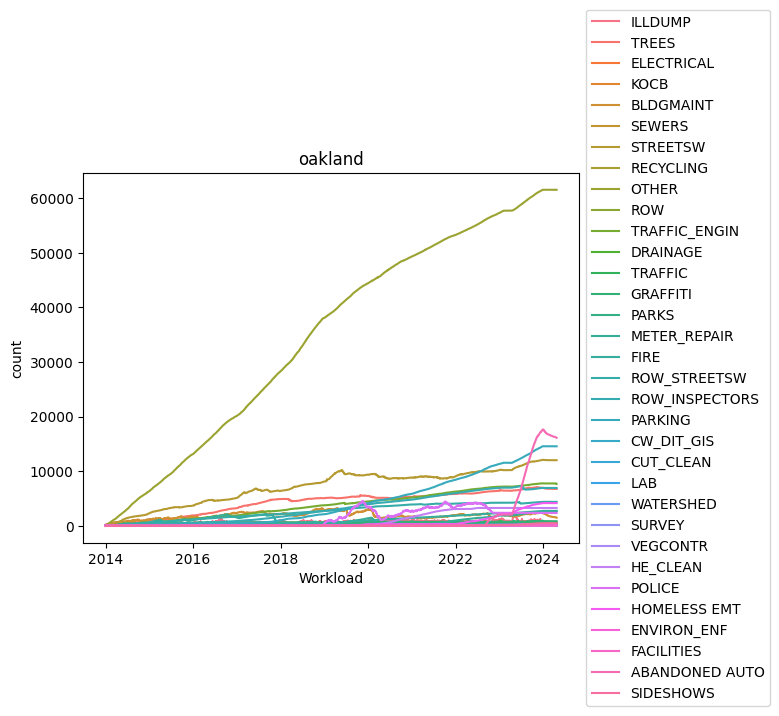

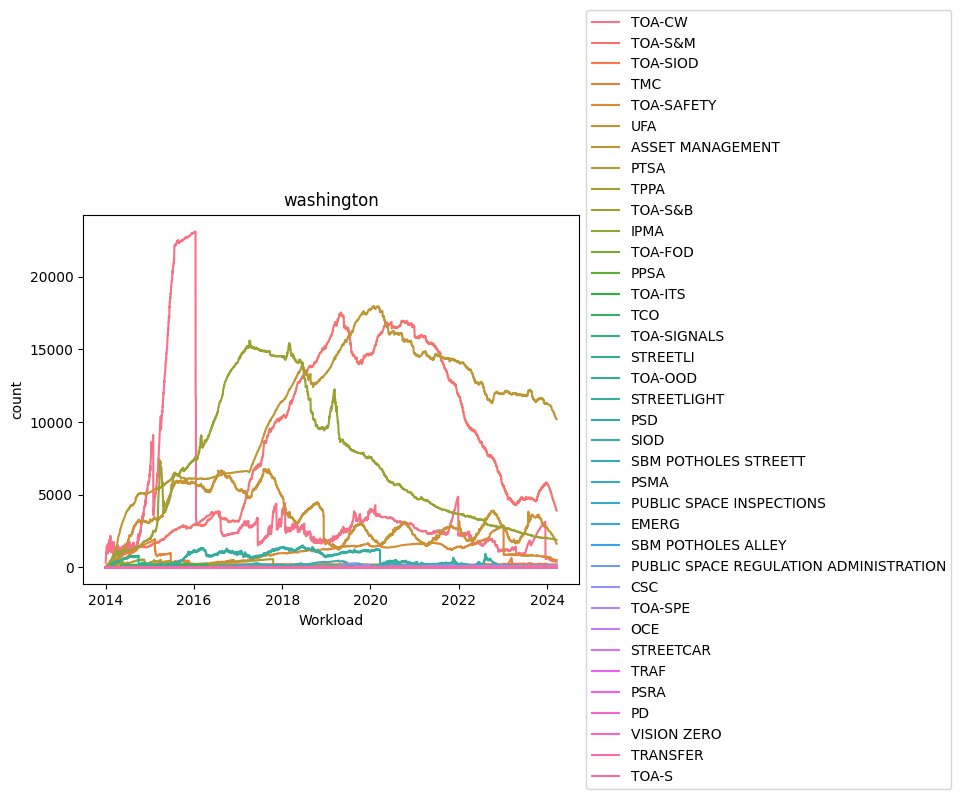

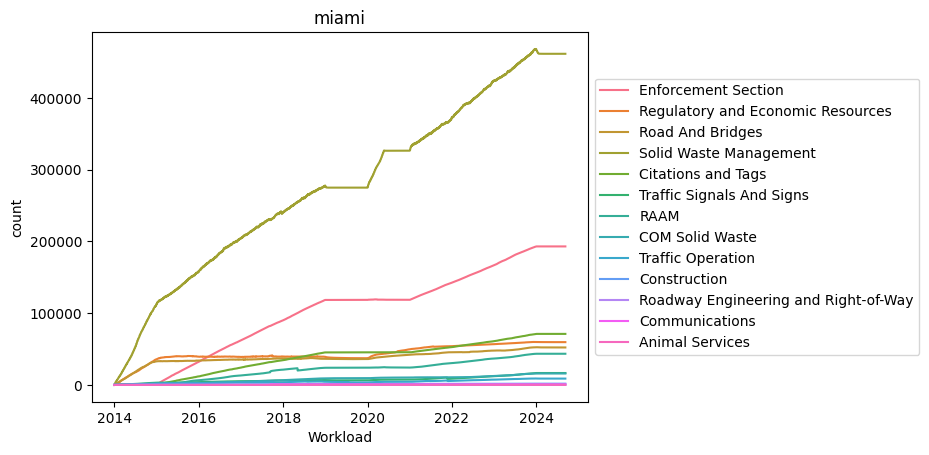

In [3]:
for w in workloads:
    plot = sns.lineplot(data=w, x="date", y="count", hue="department")
    plt.title(w['city'].unique()[0])
    plt.xlabel("Workload")
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
    plt.show()